In [3]:
#Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as image
import easygui
import pytesseract

plt.rcParams['figure.figsize'] = [10,15]#set the plot size
plt.rc('font', size=15)

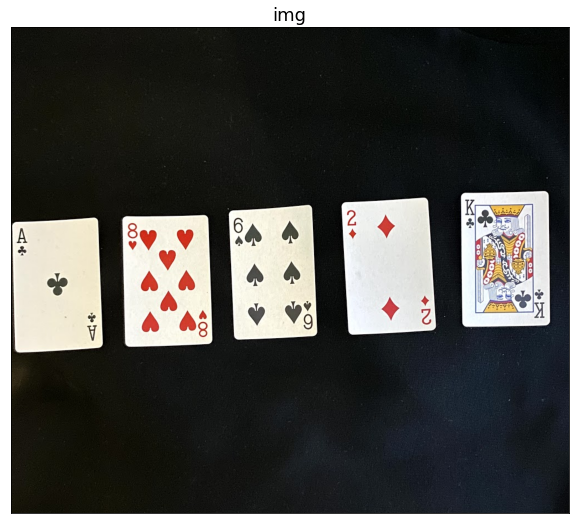

The card is: King of spades


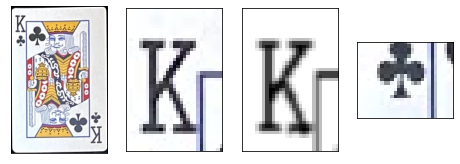

The card is: 2 of spades


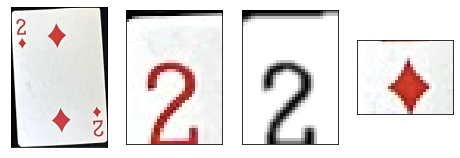

The card is: Ace of spades


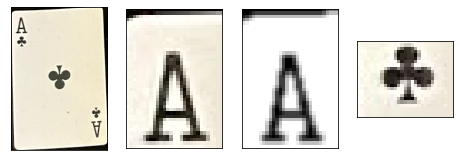

The card is: 8 of spades


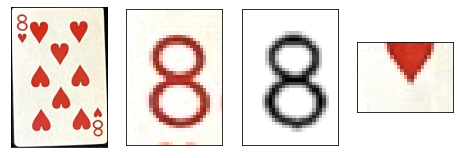

The card is: e of spades


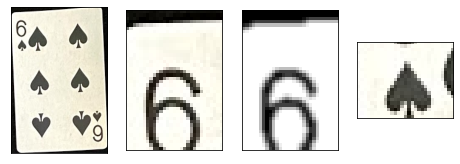

In [4]:
def GetHandType(cardLetters,cardSymbols):
    
    print(cardLetters,cardSymbols)
    
    if(cardLetters[0]==cardLetters[1] and cardLetters[1]==cardLetters[2] and cardLetters[2]==cardLetters[3] and cardLetters[3]==cardLetters[4]):
        print("Four of a kind")
    

#Use input image of the LEtter int he top left to return the card type
def GetLetter(croppedLetter,fig):
    gCroppedLetter = cv2.cvtColor(croppedLetter, cv2.COLOR_BGR2GRAY)
    #Gets a threshold
    thresh = cv2.threshold(gCroppedLetter, 130, 255, cv2.THRESH_BINARY_INV)[1]
    #Blurs it with threshold
    imBlur = cv2.GaussianBlur(thresh, (3,3), 0)
    imBlur = 255 - imBlur#Invert

    #convert to text from section of image
    textFromImage = pytesseract.image_to_string(imBlur, lang='eng',config='--psm 6')
    
    #Might have picked up some corners of images etc or included spaces so get the first individual char
    if(len(textFromImage) < 2):
        singleChar = textFromImage
    else:
        singleChar = textFromImage[0]
        #print(len(textFromImage),"characters detected: "+textFromImage+"    using char:"+singleChar)
        
    cardType = ""
    #Special cards have a name so return that
    if(singleChar == "K" or singleChar == "k"):
        cardType = "King"
    elif(singleChar == "Q"):
        cardType = "Queen"
    elif(singleChar == "J" or singleChar == "j"):
        cardType = "Jack"
    elif(singleChar == "A"):
        cardType = "Ace"
    else:#is number
        cardType = singleChar
        
    #Add to plot for displaying
    p1 = fig.add_subplot(2, 5, 3), plt.xticks([]),plt.yticks([])
    imgplot = plt.imshow(imBlur, cmap='gray')
    
    return cardType

#Use the cropped image of the symbol to return the suit
def suitComparison(club, diamond, heart, spade, inputTestImage,fig):
    # Variables for comparison
    best_rank_match_diff = 1000000000
    match = "none"
    
    # Performs comparison with heart.
    height, width, _ = heart.shape
    dim = (width, height)
    testImage = cv2.resize(inputTestImage, dim)

    diff_img = cv2.absdiff(testImage, heart)
    rank_diff = int(np.sum(diff_img)/255)               
    if rank_diff < best_rank_match_diff:
        best_rank_match_diff = rank_diff
        match = "heart"


    # Performs comparison with spade.
    height, width, _ = spade.shape
    dim = (width, height)
    testImage = cv2.resize(inputTestImage, dim)

    diff_img = cv2.absdiff(testImage, spade)
    rank_diff = int(np.sum(diff_img)/255)           
    if rank_diff < best_rank_match_diff:
        best_rank_match_diff = rank_diff
        match = "spade"


    # Performs comparison with club.
    height, width, _ = club.shape
    dim = (width, height)
    testImage = cv2.resize(inputTestImage, dim)

    diff_img = cv2.absdiff(testImage, club)
    rank_diff = int(np.sum(diff_img)/255)             
    if rank_diff < best_rank_match_diff:
        best_rank_match_diff = rank_diff
        match = "club"


    # Performs comparison with diamond.
    height, width, _ = diamond.shape
    dim = (width, height)
    testImage = cv2.resize(inputTestImage, dim)

    diff_img = cv2.absdiff(testImage, diamond)
    rank_diff = int(np.sum(diff_img)/255)      
    if rank_diff < best_rank_match_diff:
        best_rank_match_diff = rank_diff
        match = "diamond"


    p1 = fig.add_subplot(2, 5, 4), plt.xticks([]),plt.yticks([])
    imgplot = plt.imshow(inputTestImage, cmap='gray')
    
    # Prints the match with the lowest absdiff
    return match

#Use the input image to 
def readCards(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    G = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    plt.imshow(img, cmap='gray'), plt.xticks([]),plt.yticks([])
    plt.title('img')
    plt.show()
    
    T, B = cv2.threshold(G, thresh = 120, maxval = 255, type = cv2.THRESH_BINARY)
    C,_ = cv2.findContours(B, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    C = sorted(C, key=cv2.contourArea, reverse=True)
    
    # Reading in suit templates #Note: moved from inside loop
    club = cv2.imread("clubs.png")
    diamond = cv2.imread("diamonds.png")
    heart = cv2.imread("hearts.png")
    spade = cv2.imread("spades.png")
    
    cardLetters = [""]*5
    cardSymbols = [""]*5
    
    i = 0
    while i < 5:
        fig = plt.figure()#make a figure to show things on

        largestContour = C[i]
        x,y,w,h = cv2.boundingRect(largestContour)

        #Crop image to just the card
        ROI = img[y:y+h,x:x+w]
        H,W,Channels = ROI.shape

        cropped_letter = ROI[6:int(H * 0.2), 3:int(W * 0.2)]
        cropped_symbol = ROI[50:int(H * 0.3), 3:int(W * 0.2)]

        #Get cradletter from getletter method
        cardLetter = GetLetter(cropped_letter,fig )

        #Get suit from the suitComparison method
        bestMatch = suitComparison(club, diamond, heart, spade, cropped_symbol,fig)
        print("The card is: "+cardLetter+" of "+bestMatch+"s")
        
        cardLetters[i] = cardLetter
        cardSymbols[i] = bestMatch
        
        

        p1 = fig.add_subplot(2, 5, 1), plt.xticks([]),plt.yticks([])
        imgplot = plt.imshow(ROI, cmap='gray')
        p1 = fig.add_subplot(2, 5, 2), plt.xticks([]),plt.yticks([])
        imgplot = plt.imshow(cropped_letter, cmap='gray')
        plt.show()

        i = i + 1
        
    GetHandType(cardLetters,cardSymbols)
     
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

while True:
    try:
        c = cv2.waitKey(1)
        if c == 32:#IF keycode space
            break
        f = easygui.fileopenbox(filetypes=["*.jpg","*.jpeg","*.png"])#open user file select
        inputImg = cv2.imread(f)#set a file to work with
        readCards(inputImg)
        break
    except:
        print("Error using selected file")
        break
    
#inputImg = cv2.imread("4OfAKind.png")


